In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import copy
import random
import math


In [ ]:
# #### combine the logs non reporting population Rtx
# true_r1 = np.array([0.025, 0.1, 2.0, 1.0])
# median1 = np.array([0.0351, 0.2249, 1.8006, 0.8216])
# ci_lower1 = np.array([0.0132, 0.0844, 0.6758, 0.3083])
# ci_upper1 = np.array([0.0936, 0.5994, 4.7980, 2.1892])

# true_r2 = np.array([0.06, 0.286, 0.6])
# median2 = np.array([0.0598, 0.1837, 0.3198])
# ci_lower2 = np.array([0.0224, 0.0689, 0.1200])
# ci_upper2 = np.array([0.1593, 0.4894, 0.8522])


#### combine the logs
# true_r1 = np.array([0.025, 0.1, 2.0, 1.0])
# median1 = np.array([0.0351, 0.1452, 1.5427, 0.4318 ])
# ci_lower1 = np.array([0.0132, 0.0545, 0.5789, 0.1620])
# ci_upper1 = np.array([0.0936, 0.3868, 4.1111, 1.1509])

# true_r2 = np.array([0.06, 0.286, 0.6])
# median2 = np.array([0.0449, 0.1799, 0.3799])
# ci_lower2 = np.array([0.0168, 0.0675, 0.1426])
# ci_upper2 = np.array([0.1196, 0.4795, 1.0123])


#### combine the logs--- pop linear reporting
true_r1 = np.array([0.025, 0.1, 2.0, 1.0])
median1 = np.array([0.0371, 0.0895, 0.1704, 0.4820])
ci_lower1 = np.array([0.0139, 0.0336, 0.0639, 0.1809])
ci_upper1 = np.array([0.0987, 0.2385, 0.4544, 1.2844])

true_r2 = np.array([0.06, 0.3, 0.6])
median2 = np.array([0.0523, 0.1242, 0.3936])
ci_lower2 = np.array([0.0196, 0.0466, 0.1477])
ci_upper2 = np.array([0.1395, 0.3310, 1.0488])

In [2]:
import os
import glob
import re
import numpy as np

folder = "../test_rr_output_pop_local_sig/single_test/"   

# desired r-value groups (and order) -------------------------
true_r1 = np.array([0.025, 0.1, 2.0, 1.0])
true_r2 = np.array([0.06, 0.3, 0.6])

all_r_vals = np.concatenate([true_r1, true_r2])

# regex patterns --------------------------------------------
pat_rval   = re.compile(r"R_VAL=([0-9.eE+-]+)")
pat_med    = re.compile(r"Inferred r \(median\):\s*([0-9.eE+-]+)")
pat_ci     = re.compile(r"95% CI for r:\s*\[([0-9.eE+-]+),\s*([0-9.eE+-]+)\]")

# container: one list per r value ---------------------------
collect = {r: {"median": [], "low": [], "high": []} for r in all_r_vals}

def match_r_value(r_true, keys, tol=1e-8):
    """Return the key in `keys` that matches r_true (with a tolerance)."""
    for k in keys:
        if abs(k - r_true) < tol:
            return k
    return None

for fname in sorted(glob.glob(os.path.join(folder, "*.out"))):
    with open(fname, "r") as f:
        text = f.read()

    m_rval = pat_rval.search(text)
    m_med  = pat_med.search(text)
    m_ci   = pat_ci.search(text)

    if not (m_rval and m_med and m_ci):
        print(f"Skipping {fname} – pattern missing")
        continue

    r_true   = float(m_rval.group(1))
    r_median = float(m_med.group(1))
    r_low    = float(m_ci.group(1))
    r_high   = float(m_ci.group(2))

    key = match_r_value(r_true, collect.keys())
    if key is None:
        print(f"R_VAL {r_true} not in true_r1/true_r2, skipping {fname}")
        continue

    collect[key]["median"].append(r_median)
    collect[key]["low"].append(r_low)
    collect[key]["high"].append(r_high)

# convert to arrays in the same order as true_r1 / true_r2 ---
median1   = np.array([np.mean(collect[r]["median"]) for r in true_r1])
ci_lower1 = np.array([np.mean(collect[r]["low"])    for r in true_r1])
ci_upper1 = np.array([np.mean(collect[r]["high"])   for r in true_r1])

median2   = np.array([np.mean(collect[r]["median"]) for r in true_r2])
ci_lower2 = np.array([np.mean(collect[r]["low"])    for r in true_r2])
ci_upper2 = np.array([np.mean(collect[r]["high"])   for r in true_r2])

# # now you have objects shaped exactly like your screenshot:
# print("true_r1 =", true_r1)
# print("median1 =", median1)
# print("ci_lower1 =", ci_lower1)
# print("ci_upper1 =", ci_upper1)

# print("true_r2 =", true_r2)
# print("median2 =", median2)
# print("ci_lower2 =", ci_lower2)
# print("ci_upper2 =", ci_upper2)


In [3]:
# Prepare vertical error bars (on y)
yerr_lower1 = median1 - ci_lower1
yerr_upper1 = ci_upper1 - median1
yerr1 = np.vstack([yerr_lower1, yerr_upper1])

yerr_lower2 = median2 - ci_lower2
yerr_upper2 = ci_upper2 - median2
yerr2 = np.vstack([yerr_lower2, yerr_upper2])

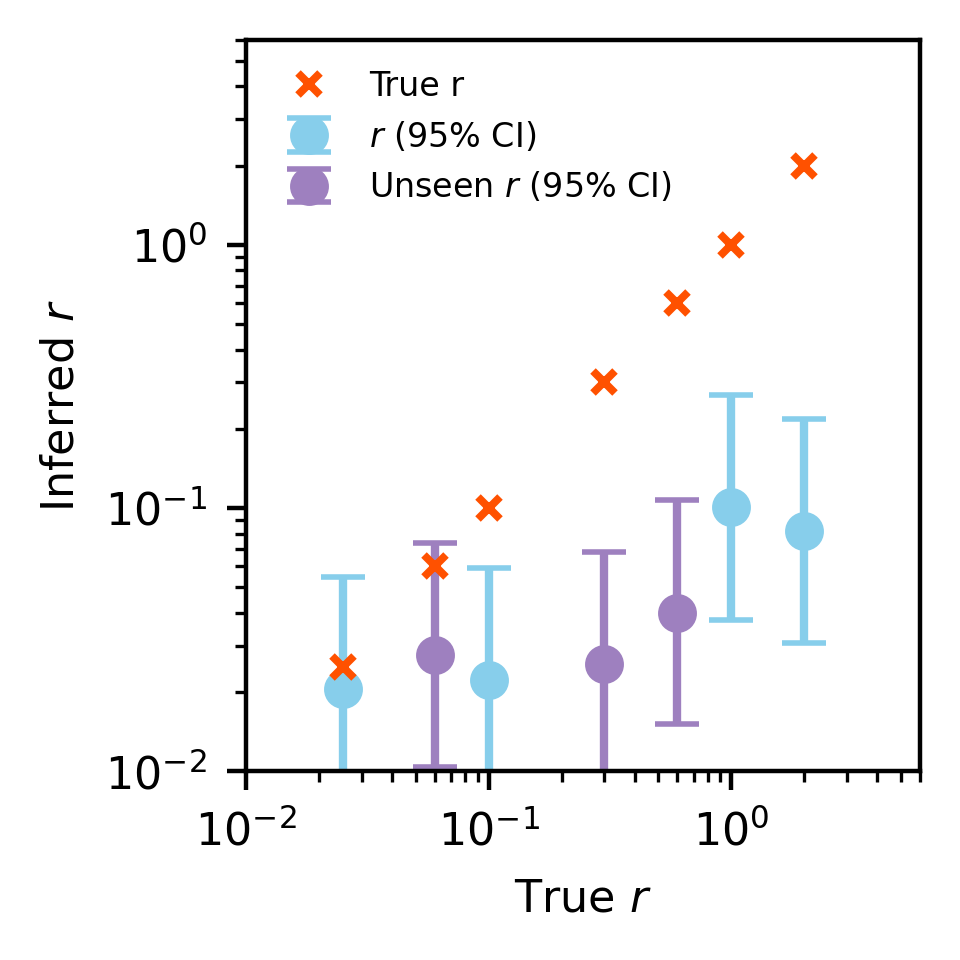

In [4]:
# Set up figure
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=400)

# Plot medians with 95% CI vertical error bars
ax.errorbar(true_r1, median1, yerr=yerr1, fmt='o', capsize=4, label="$r$ (95% CI)",color='#87ceeb',zorder=2)
ax.plot(true_r1, true_r1, 'x', color='#ff5100',ms=4, mew=1.4, label="True r",zorder=5)

ax.errorbar(true_r2, median2, yerr=yerr2, fmt='o', capsize=4, label="Unseen $r$ (95% CI)",color='#9e80bf',zorder=2)
ax.plot(true_r2, true_r2, 'x', color='#ff5100',ms=4,mew=1.4, zorder=5 )

# Log scales
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and title
ax.set_xlabel("True $r$",size=8)
ax.set_ylabel("Inferred $r$",size=8)
# ax.set_title("Inferred vs True r (log–log)")

ax.tick_params(axis='both', which='major', labelsize=8)

ax.set_xlim(0.01, 6)
ax.set_ylim(0.01, 6)
ax.legend(frameon=False, fontsize=6, loc='upper left')

plt.tight_layout()

# Save
# out_path = "../results/Rtx/inferred_vs_true_r_nrr.png"
# plt.savefig(out_path, dpi=400, bbox_inches='tight')
# out_path